# In this notebook, we used code to train and generate images based on the German Traffic Sign Recognition Benchmark (GTSRB) dataset.


### Part of this code was adapted from a blogs designed by [Jason Brownlee](https://machinelearningmastery.com/) I suggest anyone interested in this field of study shoud follow his blogs and get enlightened. 

### Original credit goes to Jason. 

### Let's import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import random
import keras
from keras.utils import to_categorical
import pickle
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
#from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot as plt


2023-02-20 13:09:55.689564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 13:09:55.921534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 13:09:55.921549: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 13:09:56.683906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Load data and plot to get a quick understanding

In [2]:
# Load pickled data
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Let's visualize the data

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


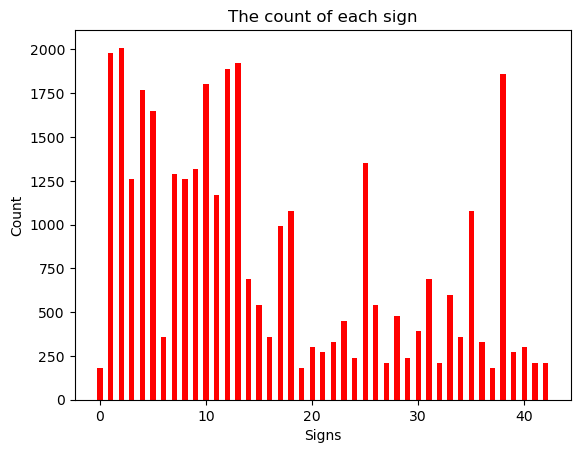

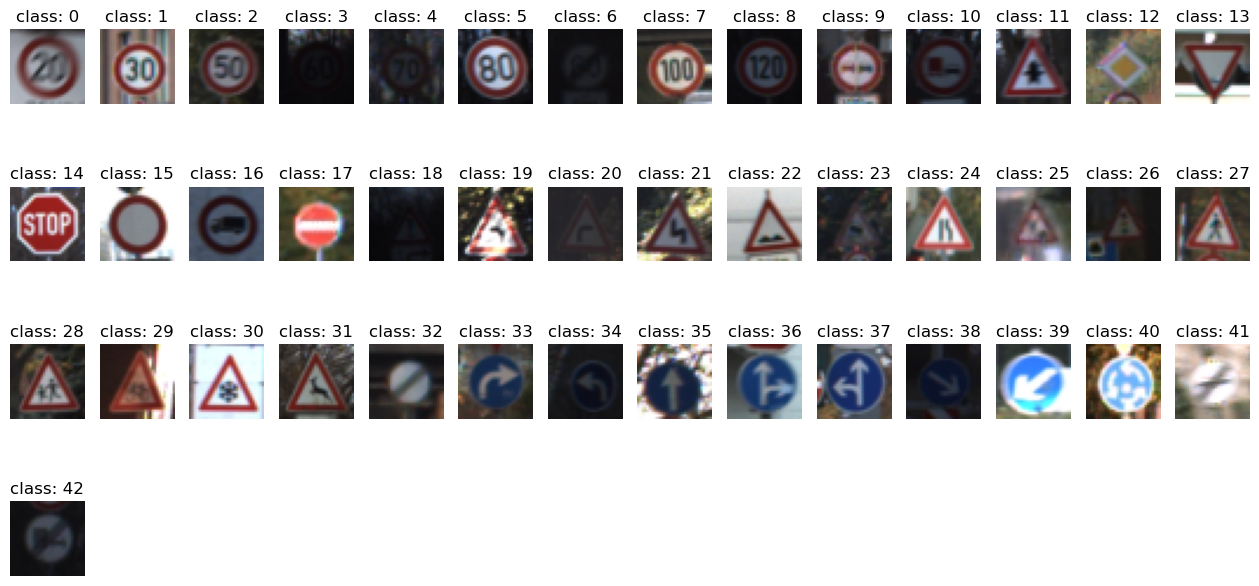

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 14, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

### To simplify the model definition process, we will utilize Keras' Sequential method to define the generator, discriminator, and other helper functions. For the conditional GAN, we will use a functional approach to define the model, while for the generator and discriminator, which are more straightforward, we will use the sequential approach.

## Let's define the standalone discriminator model

In [5]:

def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) 
    lr = 0.0002
    
# compile model
    opt = Adam(learning_rate=lr, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

2023-02-20 13:10:34.954462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-20 13:10:34.954660: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-20 13:10:34.954681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lasige-OptiPlex-5090): /proc/driver/nvidia/version does not exist
2023-02-20 13:10:34.955041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Let's define the standalone generator model


#### The generator takes in latent vector as input and generators out. Therefore, the generator's output must be the size that you want the generated image size to be.


#### Given input of latent vector, the Generator produces an image.(here: 32x32) latent_dim, for example, can be 100, 1D array of size 100. Here we are only using Dense and conv2dlayers. But network can be complicated based on the application. For example, you can use VGG or any other model for super res. GAN.



#### We will also reshape input latent vector into 8x8 image as a starting point. Therefore, n_nodes for the Dense layer can be 128x8x8. Now when we reshape the output it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.

In [8]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
    model = Sequential()

    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
    
# upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    
# upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    
# generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

## Let's train the combined GAN model

#### Let's define the combined generator and discriminator model, for updating the generator. The discriminator is trained separately so here only generator will be trained by keeping the discriminator constant. 

In [9]:
def define_gan(generator, discriminator):
    discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
# connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


### Let's load training images

In [10]:
def load_real_samples():
    #(X_train, _), (_, _) = load_data()
# Convert to float and scale.

    X = X_train.astype('float32')

    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
    return X


### pick a batch of random real samples to train the GAN. In fact, we will train the GAN on a half batch of real images and another half batch of fake images. For each real image we assign a label 1 and for fake we assign label 0. 

### This function will generate real images

In [11]:
def generate_real_samples(dataset, n_samples):

# choose random images
    ix = randint(0, dataset.shape[0], n_samples)

# select the random images and assign it to X
    X = dataset[ix]
    
# generate class labels and assign to y
    y = ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y



### This function will generate n_samples number of "latent vectors" as input for the generator

In [12]:
def generate_latent_points(latent_dim, n_samples):
    
# generate points in the latent space
    x_input = randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

### Now let defind a function that will use the generator to generate n fake examples, with class labels. Then we will supply the generator with latent_dim and number of samples as input. We will lastly use the above latent point generator to generate latent points.

In [13]:
 def generate_fake_samples(generator, latent_dim, n_samples):

        # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)

    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)

    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

## Let's train the generator and discriminator. We loop through a number of epochs to train our Discriminator by:

### 1. Selecting a random batch of images from our true/real dataset.

### 2. Generating a set of images using the generator. 

### 3. Feeding both set of images into the Discriminator. 

### 4. Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

In [18]:
 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 3)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 

        
        # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
    
    # enumerate batches over the training set
        for j in range(bat_per_epo):
          
        
        
            # Train the discriminator on real and fake images, separately (half batch each). Research showed that separate training is more effective. Let's get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)

            
            
            # update discriminator model weights, train_on_batch allows you to update weights based on a collection  of samples you provide. Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 

            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
           # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            
            
            # The generator wants the discriminator to label the generated samples as valid (ones). This is where the generator is trying to trick discriminator into believing the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            
            
# Generator is part of combined model where it got directly linked with the discriminator. we will train the generator with latent_dim as x and 1 as y. Again, 1 as the output as it is adversarial and if generator did a greatjob of folling the discriminator then the output would be 1 (true)

           # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                   (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

            
            # save the generator model

    g_model.save('save_models/GTSRB_generator_2epochs.h5')


## Let's train the GAN

In [19]:
# size of the latent space
latent_dim = 100

# create the discriminator
discriminator = define_discriminator()

# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)

# load image data
dataset = load_real_samples()

# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=1)

/home/lasige/anaconda3/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 18ms/step
Epoch>1, Batch 1/271, d1=0.670, d2=0.697 g=0.690
2/2 [==============================] - 0s 18ms/step
Epoch>1, Batch 2/271, d1=0.615, d2=0.705 g=0.682
2/2 [==============================] - 0s 17ms/step
Epoch>1, Batch 3/271, d1=0.548, d2=0.716 g=0.673
2/2 [==============================] - 0s 17ms/step
Epoch>1, Batch 4/271, d1=0.496, d2=0.731 g=0.664
2/2 [==============================] - 0s 20ms/step
Epoch>1, Batch 5/271, d1=0.423, d2=0.741 g=0.656
2/2 [==============================] - 0s 17ms/step
Epoch>1, Batch 6/271, d1=0.378, d2=0.756 g=0.648
2/2 [==============================] - 0s 20ms/step
Epoch>1, Batch 7/271, d1=0.350, d2=0.790 g=0.627
2/2 [==============================] - 0s 17ms/step
Epoch>1, Batch 8/271, d1=0.296, d2=0.835 g=0.606
2/2 [==============================] - 0s 17ms/step
Epoch>1, Batch 9/271, d1=0.296, d2=0.899 g=0.575
2/2 [==============================] - 0s 17ms/step
Epoch>1, Batch 10/271, d1=0.272, d2=0.9

### Now, let us load the generator model and generate some fake images

In [20]:
from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()



### Let's load the model and generate some images

In [25]:

model = load_model('save_models/GTSRB_generator_2epochs.h5') #Model trained for 100 epochs

# generate images
latent_points = generate_latent_points(100, 36)  #Latent dim and n_samples
# generate images

### Predict and plot the images. Note that, if you want to have a good latent prediction, you need to training the model with many epohs and batch size. However, you need strong GPU to do that

2/2 [==============================] - 0s 12ms/step


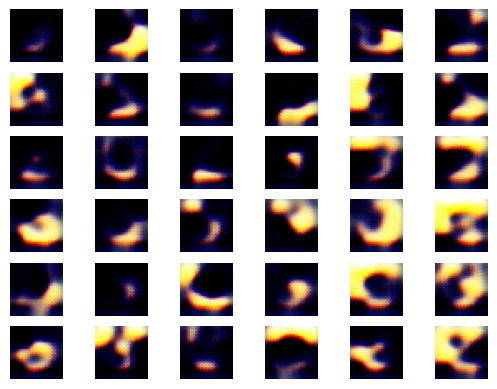

In [38]:
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0



## Remember, we converted our images to values between -1 and 1. Now we have to rescale them back to 0-255.
import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
#fig, ax = plt.subplots()
#plt.figure(figsize=(10, 10))
plt.show()
show_plot(X, 6)

